### Stocastic Search & Mutation

In [20]:
import random
import string
import pandas as pd
import math
import matplotlib.pyplot as plt

In this example, we are going to have a set of strings or sentences as goal. And we are going to initialize our first solution from random strings from string.printable. Solutions will be evaluated to see how "far" are they from our goal. Solution with score would mean further away from goal.

Random mutation will be introduced. This approach is also known as Hill climbing by mutation and random choice appraoch. If the new found solution is better solution than the previous one, it will discard the previous one and take the current solution. Mutation will repeat until it reaches goal. Number of mutation will be recorded, trend of fitness converging to 0 will also be shown in the end.

Finally this will be compared to Genetic Algorithm approach to understand the difference in this case.

In [13]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [44]:
def generate_random_solution():
    solution = ""
    for i in range(len(goal)):
        solution = solution+ random.choice(string.printable)
    return solution

In [45]:
def evaluate(solution, goal):
    score = 0
    for i in range(len(solution)):
        score += abs(ord(solution[i]) - ord(goal[i]))
    return score

In [46]:
def mutation(solution):
    solution_ = [i for i in solution]
    solution_[random.choice(range(0,len(solution)))] = random.choice(string.printable)
    solution = ''.join(solution_)
    return solution

In [47]:
goal= "Hello, world!"
best_sol = generate_random_solution()
mutate_count = 0
best_score = evaluate(best_sol, goal)
score_lst = []

while len(best_sol) == len(goal):
    score_lst.append(best_score)
#     print(f'Best possible score is {best_score}, word is {best_sol}')
#     print(f'doing random mutation #{mutate_count}')
    if best_score == 0:
        break
    solution = mutation(best_sol)
    score = evaluate(solution, goal)
    mutate_count += 1
    if score < best_score:
        best_sol = solution
        best_score = score

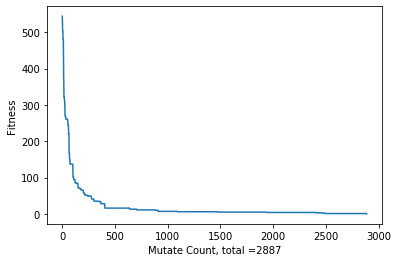

In [48]:
plt.plot(score_lst)
plt.ylabel('Fitness')
plt.xlabel(f'Mutate Count, total ={mutate_count}')
plt.show()

Mutation count will vary between 2500 to 8000 generations, as it involves a lot of randomness, until it reaches 0. And you can see from the fitness declining trend, there is only downwards, because solution is only accepted if it is better, else it is being discarded and the search continues.

Now, let us look at Genetic Algorithm.

### Genetic Algorithm

For Genetic Algorithm (GA), instead of single solution being mutated over and over, GA approach is evolution of entire population. To simuate this, we will need to initialize a population of solution.

Same thing, we will randomly initialize solution for a population size that we define. We also define our Surviving Rate (known as elite size in this example, where the fittest of the fittest in the population get retained over and over generation). 

Next is Selection process, where we use Roulette Wheel / Wheel of Fortune to select a few of fitter solutions to replace the weaker solutions (by probability) in that population. From the selected population, we select a few solutions for crossover, based on crossover rate. Elite solutions will not be replaced or changed to keep the gene in the pool. Next is Mutation of single character in solutions, according to mutation rate. Again, elite solution will not be mutated. The result of these series of process will produce a new generation.

This entire process is looped until stop criteria is reached i.e. number of generation defined.
Fitness trend will be plot against generations. Different mutation rate and crossover rate are also trialed to study the correlation to ultimate fitness of population.


In [49]:
#generate random solution for popsize given, and goal set

def generate_random_solution(popsize, goal):
    solution_lst = []
    for j in range(popsize):
        solution = ""
        for i in range(len(goal)):
            solution = solution+ random.choice(string.printable)
        solution_lst.append(solution)
    return solution_lst

In [50]:
#fitness function for each solution and goal

def evaluate(solution, goal):
    score = 0
    for i in range(len(solution)):
        score += abs(ord(solution[i]) - ord(goal[i]))
    return score

In [51]:
#sort current generation according to its fitness
#return (index of current gen, fitness fn)

def rank(current_gen):
    lst = []
    for i,sol in enumerate(current_gen):
        lst.append((i,evaluate(sol, goal)))
    return sorted(lst,key = lambda x: x[1])

In [52]:
#do selection based on their fitness, and cummulative probability. Select elite_size to keep
#if elite_size is 3, top 3 will be kept in the generation
#elite_size here is like surviving rate

def selection(current_gen, elite_size):
    ranked_gen = rank(current_gen)    
    
    #select top elite_size, append to list
    selection_lst = []
    for i in range(elite_size):
        selection_lst.append(current_gen[ranked_gen[i][0]])
    
    #for remaining, do selection based on probability
    df = pd.DataFrame(ranked_gen,columns=['index','fitness'])
    df['probability'] = df['fitness'] / df['fitness'].sum()
    df['cumsum'] = df['probability'].cumsum()
    
    for i in range(len(current_gen) - elite_size):
        r = random.random()
        for j in range(len(df)):
            if r < df.iat[j,3]:
                selection_lst.append(current_gen[df.iat[j-1,0]])
                break
    return selection_lst

In [53]:
#breeding function for crossover
#take in string

def breed(parent1, parent2, cross_length=0.1):
    cross_char = math.ceil(cross_length*len(parent1))
    cross_point = random.randint(1, len(parent1)-cross_char)
       
    child1 = parent1[:cross_point] + parent2[cross_point:cross_point+cross_char] + parent1[cross_point+cross_char:]
    #child2 = parent2[:cross_point] + parent1[cross_point:cross_point+cross_char] + parent2[cross_point+cross_char:]
    return child1 #, child2

In [37]:
#do crossover. Crossover does not include fitness consideration, but solely on crossover rate.
#elite_size can be kept, top 3 will be retained. This elite_size should be the same as selection's elite_size as 
#Fn will assume no change in order.
#the rest will be subject to crossover rate.

def crossover(selection_lst, elite_size, crossover_rate=0.4):
    crossover_lst = []
    #put first n from elite_size into list
    for i in range(elite_size):
        crossover_lst.append(selection_lst[i])
        
    #generate the rest of children and replace their parents
    for i in range(elite_size,len(selection_lst)):
        if random.random() < crossover_rate:
            #crossover
            parent1 = i
            parent2 = random.choice([j for j in range(0,len(selection_lst)) if j not in [i]])
            child = breed(selection_lst[i], selection_lst[parent2])
            crossover_lst.append(child)
        else:
            crossover_lst.append(selection_lst[i])
    return crossover_lst

In [54]:
#Do mutation based on mutation rate. Random choice of a word, mutate randomly.

def mutation(crossover_lst, mutation_rate = 0.1):
    mutation_lst= []
    for sol in crossover_lst:
        if random.random()<0.1:
            solution_ = [i for i in sol]
            solution_[random.choice(range(0,len(sol)))] = random.choice(string.printable)
            mutation_lst.append(''.join(solution_))
        else:
            mutation_lst.append(sol)
    return mutation_lst

In [55]:
#for iteration of next generation

def nextgeneration(current_gen, elite_size, crossover_rate, mutation_rate):
    selection_lst = selection(current_gen, elite_size)
    crossover_lst = crossover(selection_lst, elite_size, crossover_rate=0.4)
    next_gen = mutation(crossover_lst, mutation_rate)
    return next_gen

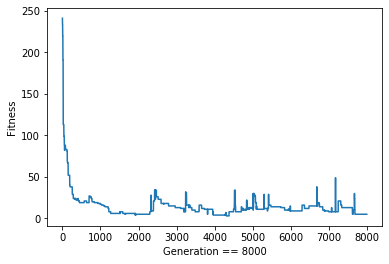

Best result : Hflno Worlc" 5


In [40]:
goal = "Hello World!"
popsize = 10
crossover_rate = 0.2
mutation_rate = 0.9
elite_size = 3
gen = 8000

current_gen = generate_random_solution(popsize, goal)
fitness_best = []
fitness_worst = []
sum_fitness = []

for i in range(gen):
    current_gen = nextgeneration(current_gen, elite_size, crossover_rate, mutation_rate)
    fitness_best.append(rank(current_gen)[0][1])
    fitness_worst.append(rank(current_gen)[-1][1])
    sum_fitness.append(sum([i[1] for i in rank(current_gen)]))
    
plt.plot(fitness_best)
#plt.plot(fitness_worst)
plt.ylabel('Fitness')
plt.xlabel(f'Generation == {gen}')
plt.show()

print('Best result :', current_gen[0], rank(current_gen)[0][1])

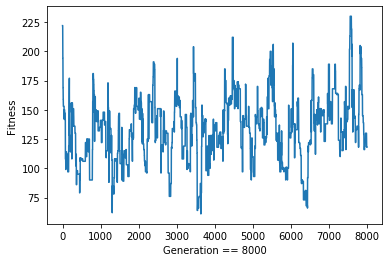

Best result : Pewfa1Fntek= 118


In [41]:
goal = "Hello World!"
popsize = 100
crossover_rate = 0.2
mutation_rate = 0.9
elite_size = 3
gen = 8000

current_gen = generate_random_solution(popsize, goal)
fitness_best = []
fitness_worst = []
sum_fitness = []

for i in range(gen):
    current_gen = nextgeneration(current_gen, elite_size, crossover_rate, mutation_rate)
    fitness_best.append(rank(current_gen)[0][1])
    fitness_worst.append(rank(current_gen)[-1][1])
    sum_fitness.append(sum([i[1] for i in rank(current_gen)]))
    
plt.plot(fitness_best)
#plt.plot(fitness_worst)
plt.ylabel('Fitness')
plt.xlabel(f'Generation == {gen}')
plt.show()

print('Best result :', current_gen[0], rank(current_gen)[0][1])

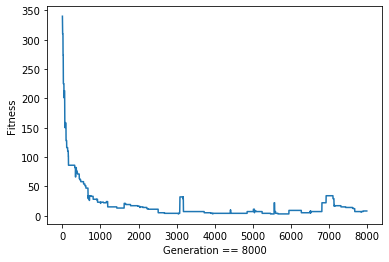

Best result : Hello Wlolb! 8


In [56]:
goal = "Hello World!"
popsize = 5
crossover_rate = 0.2
mutation_rate = 0.9
elite_size = 3
gen = 8000

current_gen = generate_random_solution(popsize, goal)
fitness_best = []
fitness_worst = []
sum_fitness = []

for i in range(gen):
    current_gen = nextgeneration(current_gen, elite_size, crossover_rate, mutation_rate)
    fitness_best.append(rank(current_gen)[0][1])
    fitness_worst.append(rank(current_gen)[-1][1])
    sum_fitness.append(sum([i[1] for i in rank(current_gen)]))
    
plt.plot(fitness_best)
#plt.plot(fitness_worst)
plt.ylabel('Fitness')
plt.xlabel(f'Generation == {gen}')
plt.show()

print('Best result :', current_gen[0], rank(current_gen)[0][1])

With higher population like 100, we are introducing a lot of random strings, and the population just doesn't converge to a better solution. We may need a lot of generations for that to work.

Now we do higher crossover rate and lower mutation rate.

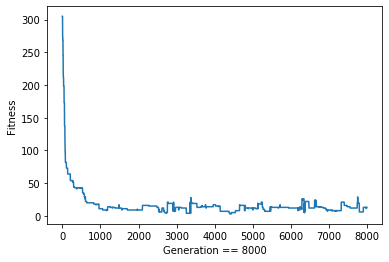

Best result : Fello Wmklb# 13


In [58]:
goal = "Hello World!"
popsize = 10
crossover_rate = 0.6
mutation_rate = 0.2
elite_size = 3
gen = 8000

current_gen = generate_random_solution(popsize, goal)
fitness_best = []
fitness_worst = []
sum_fitness = []

for i in range(gen):
    current_gen = nextgeneration(current_gen, elite_size, crossover_rate, mutation_rate)
    fitness_best.append(rank(current_gen)[0][1])
    fitness_worst.append(rank(current_gen)[-1][1])
    sum_fitness.append(sum([i[1] for i in rank(current_gen)]))
    
plt.plot(fitness_best)
#plt.plot(fitness_worst)
plt.ylabel('Fitness')
plt.xlabel(f'Generation == {gen}')
plt.show()

print('Best result :', current_gen[0], rank(current_gen)[0][1])

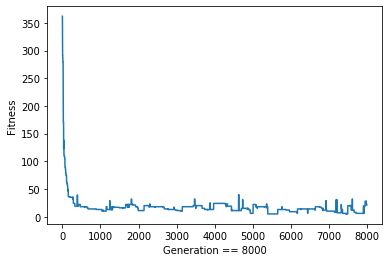

Best result : Hgjoo Wbrld" 21


In [59]:
goal = "Hello World!"
popsize = 10
crossover_rate = 0.8
mutation_rate = 0.1
elite_size = 3
gen = 8000

current_gen = generate_random_solution(popsize, goal)
fitness_best = []
fitness_worst = []
sum_fitness = []

for i in range(gen):
    current_gen = nextgeneration(current_gen, elite_size, crossover_rate, mutation_rate)
    fitness_best.append(rank(current_gen)[0][1])
    fitness_worst.append(rank(current_gen)[-1][1])
    sum_fitness.append(sum([i[1] for i in rank(current_gen)]))
    
plt.plot(fitness_best)
#plt.plot(fitness_worst)
plt.ylabel('Fitness')
plt.xlabel(f'Generation == {gen}')
plt.show()

print('Best result :', current_gen[0], rank(current_gen)[0][1])

As we increase the crossover rate and reduce the rate of mutation, it does seem like it is performing worse. Then again, all these are happening in random motion.
What is certain is that, it is extremely hard for GA to arrive at 0 fitness score. Even if it did, it will take a lot of computational efforts for the population to arrive to that.